# Employment by sector and departement

In [1]:
from pynsee.localdata import *
from pynsee.geodata import *
from pynsee.metadata import *
from shapely import wkt

import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import seaborn as sns
import math

from matplotlib.pyplot import pie
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# get a list all data available : datasets and variables
metadata = get_local_metadata()

# geographic metadata
nivgeo = get_nivgeo_list()

!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!
!!! This function renders only package's internal data,
it might not be the most up-to-date
Have a look at api.insee.fr !!!


In [2]:
# get departement map
dep = get_geodata('ADMINEXPRESS-COG-CARTO.LATEST:departement')

dep = dep.translate(departement=['971', '972', '974', '973', '976'],
                   factor=[1.5, 1.5, 1.5, 0.3, 1.5])
dep = dep.zoom(factor = 3.5 , angle = math.pi * (1 - 3 * 1/9))

dep = dep[["insee_dep", "geometry"]]

dep = dep.rename(columns={'insee_dep': 'CODEGEO'})
dep

Previously saved data used
/home/jovyan/.cache/pynsee/pynsee/399f6d97ce4631c4e02c487406744440
Set update=True to get the most up-to-date data


,CODEGEO,geometry
0,971,(POLYGON ((-760467.2011270802 6295735.72612485...
1,972,(POLYGON ((-748274.3653262919 6042884.54441536...
2,974,(POLYGON ((-824213.6315865126 5872475.58982470...
3,973,(POLYGON ((-721872.2006725753 5707593.36553416...
4,976,(POLYGON ((-554892.2682969039 5442650.54160681...
...,...,...
100,95,"(POLYGON ((271116.09678243 6297637.40344712, 2..."
101,75,(POLYGON ((-465010.5905198271 6514698.85265384...
102,92,(POLYGON ((-521040.0841878771 6576426.99999967...
103,93,(POLYGON ((-427886.0972296421 6596852.02282196...


In [3]:
# get local data from INSEE API
data = get_local_data(dataset_version = 'GEO2020FLORES2017',
                     variables =  'NA17',
                     nivgeo = 'DEP')
data = data.rename(columns={'NA17': 'A17'})

Getting departements: 100%|██████████| 18/18 [00:29<00:00,  1.66s/it]


By default, the query is on all departements


Getting data:  10%|▉         | 10/102 [00:01<00:15,  6.12it/s]


API query number limit reached - function might be slowed down


Getting data: 100%|██████████| 102/102 [03:36<00:00,  2.12s/it]

Data saved: /home/jovyan/.cache/pynsee/pynsee/70e55d709888018cd0f1c6bd3db6a9b2


In [4]:
# keep only headcounts and remove the total from the data
df = data[data["UNIT"] == "NBSALET"].reset_index(drop=True)
df = df[~df["A17"].isin(["ENS"])].reset_index(drop=True)

In [5]:
# compute share of activity in total employment by department
df['employment_share'] = 100 * df["OBS_VALUE"] / df['OBS_VALUE'].groupby(df['CODEGEO']).transform('sum')

In [6]:
# merge values and geographic limits
datamap = df.merge(dep, how = 'left', on = 'CODEGEO')
datamap = gpd.GeoDataFrame(datamap)

In [7]:
# add english activity labels at A17 level
activity = get_activity_list("A17")
activity["TITLE_A17_EN"] = activity["A17"] + " - " + activity["TITLE_A17_EN"]
datamap = datamap.merge(activity, how='left', on='A17')

In [8]:
# compute center location for each departement
def get_center(x):
    return x.centroid.wkt

datamap["center"] = datamap['geometry'].apply(lambda x: get_center(x))

# list of departements
list_dep = datamap["CODEGEO"].unique() 

In [9]:
# make color palette
colors = sns.color_palette("Set1") + sns.color_palette("Set2")

# order activity sectors according to average share
emplTot = datamap[["employment_share", "TITLE_A17_EN"]].groupby(datamap['TITLE_A17_EN']).mean()
emplTot = emplTot.sort_values(by=["employment_share"],  ascending=False)

datamap["TITLE_A17_EN"] = datamap["TITLE_A17_EN"].astype(CategoricalDtype(categories=emplTot.index, ordered=True))
datamap = datamap.sort_values(["TITLE_A17_EN"]).reset_index(drop=True)
datamap

,CODEGEO,NIVGEO,UNIT,UNIT_label_fr,A17,OBS_VALUE,NA17_label,DATASET_VERSION,DATASET_NAME,DATA_DATE,GEO_DATE,CODEGEO_label,employment_share,geometry,A5,A10,TITLE_A17_EN,TITLE_A17_FR,center
0,92,DEP,NBSALET,Postes salariés dans les établissements,OQ,193252.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Hauts-de-Seine,17.574866,"MULTIPOLYGON (((-521040.084 6576427.000, -5194...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-511038.2200621507 6533184.219504979)
1,15,DEP,NBSALET,Postes salariés dans les établissements,OQ,19902.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Cantal,43.825421,"MULTIPOLYGON (((234011.357 5631328.379, 234095...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (297132.1847237096 5629739.68843575)
2,40,DEP,NBSALET,Postes salariés dans les établissements,OQ,41579.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Landes,34.439944,"MULTIPOLYGON (((-150466.072 5465682.645, -1504...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-87229.51844599277 5460398.995074544)
3,14,DEP,NBSALET,Postes salariés dans les établissements,OQ,90141.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Calvados,35.919618,"MULTIPOLYGON (((-47856.437 6251825.615, -47735...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (-40231.4420775164 6291926.870039062)
4,04,DEP,NBSALET,Postes salariés dans les établissements,OQ,19565.0,"Administration publique, enseignement, santé h...",GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Alpes-de-Haute-Provence,40.993568,"MULTIPOLYGON (((626874.471 5488749.945, 627113...",OQ,OQ,"OQ - Public administration and defence, educat...","Administration publique, enseignement, santé h...",POINT (695212.592539985 5482087.622821789)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1780,31,DEP,NBSALET,Postes salariés dans les établissements,C2,26.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Haute-Garonne,0.004384,"MULTIPOLYGON (((117041.418 5415884.623, 117066...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (130916.0801959664 5367032.990126808)
1781,90,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Territoire de Belfort,0.000000,"MULTIPOLYGON (((755903.679 6048474.372, 755844...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (771284.3142524358 6045847.551103318)
1782,41,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Loir-et-Cher,0.000000,"MULTIPOLYGON (((93147.979 6108318.685, 93085.6...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (158851.7025015785 6043580.709749965)
1783,83,DEP,NBSALET,Postes salariés dans les établissements,C2,0.0,Cokéfaction et raffinage,GEO2020FLORES2017,Fichier localisé des rémunérations et de l'emp...,2017,2020,Var,0.000000,"MULTIPOLYGON (((696715.041 5311473.208, 696709...",BE,BE,C2 - Manufacture of coke and refined petroleum...,Cokéfaction et raffinage,POINT (695161.7441772111 5379580.598117414)


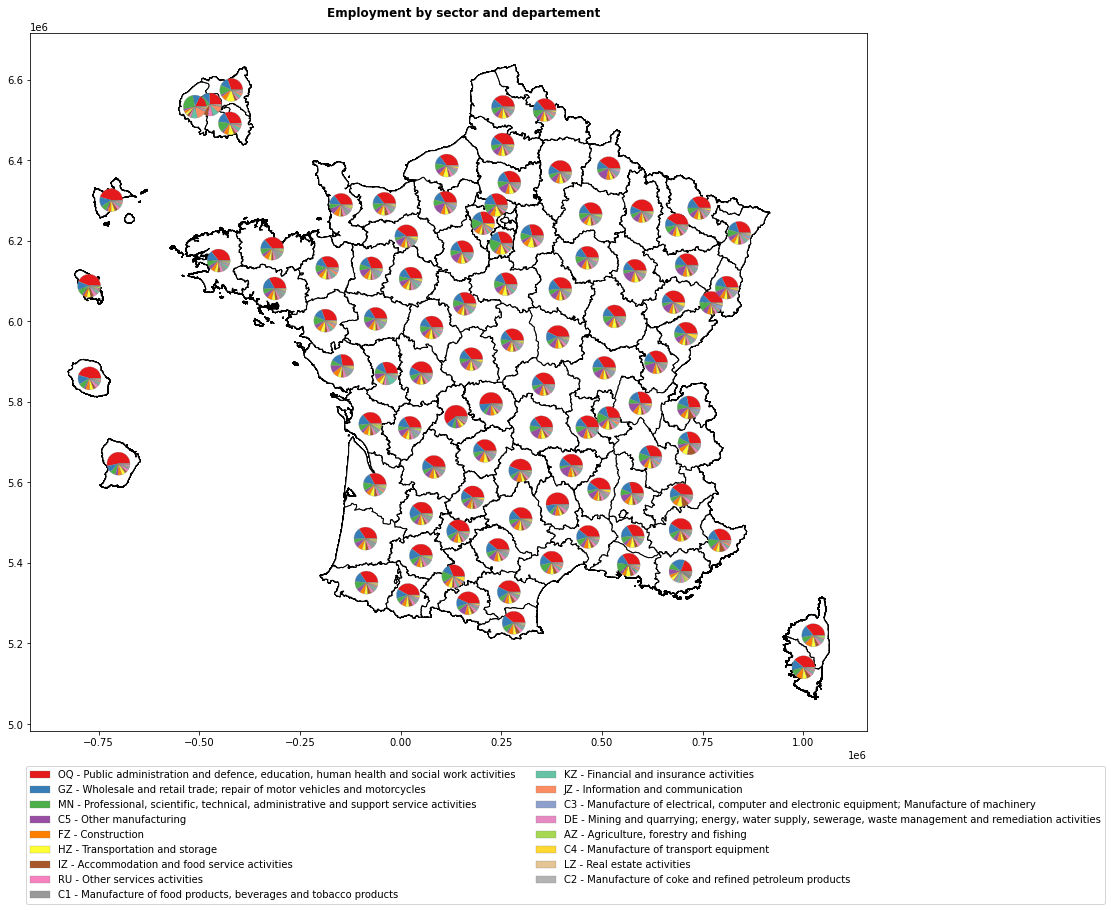

In [10]:
# draw plot

def extract_lon(x):    
    return wkt.loads(x).xy[0][0]
def extract_lat(x):    
    return wkt.loads(x).xy[1][0]

ax = datamap.plot(color='white', edgecolor='black', figsize = (15,15))

for idep in list_dep:
    df = datamap[datamap["CODEGEO"] == idep].reset_index(drop=True)   
    df["lon"] = df["center"].apply(lambda x: extract_lon(x))
    df["lat"] = df["center"].apply(lambda x: extract_lat(x))
    
    df = df[df["lon"] == min(df["lon"])].reset_index(drop=True)
    center = df.loc[0,"lon"], df.loc[0,"lat"]
    
    ratios = df["employment_share"]
    
    ax_sub = inset_axes(ax, width=0.4, height=0.4, loc=10, bbox_to_anchor=center, bbox_transform=ax.transData)
    ax_sub.pie(ratios, wedgeprops={'edgecolor': 'gray','linewidth': 0.25}, colors = colors)
    
plt.suptitle('Employment by sector and departement', x = 0.4, y = 0.85,
            horizontalalignment= 'left',
            fontsize = 12, fontweight='bold')
plt.legend(emplTot.index, loc="lower left", bbox_to_anchor=(-27, -9), ncol=2)

plt.show()